# The effectiveness of SHAP for retrieving biologically important genera

In [20]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xgboost as xgb
import dask.array as da
import dask.distributed

wkdir = Path('/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome/')
results = wkdir / 'results'

## Data Preprocessing

### Load data

In [34]:
genus_df = pd.read_csv(wkdir / 'data/temp_files_9999/07_abundance_matrix/genus_RA.n8728.csv')
n_taxa = 612
X = genus_df.iloc[:, 1:n_taxa + 1]
meta = genus_df.iloc[:, n_taxa + 1:]
X.head()
meta.head()

,multiplex_pool_id,supplier_id,gis_internal_sample_id,site_supplying_sample,year_of_birth,supplied_gender,self_reported_ethnicity,extraction_kit,date_of_dna_extraction,plate_position,...,sequencing_complete,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info,duplicate,duplicate_pair
0,MUX5172,CG-CTR-0454,TTSH_CG_CTR_0454_1,TTSH,1987,F,Indian,QIAamp DNA Blood Mini Kit,24/09/2014,E10,...,Y,Y,Y,TTSH VCF,Y,TTSH_mini,CG-CTR-0454,Unknown,PASS,Unknown
1,MUX10495,17003-2474,MEC_17003_2474_1,MEC,1980,F,Indian,Maxwell RSC Blood DNA Kit (AS1400),1/12/2018,H2,...,Y,Y,Y,MEC VCF,Y,MEC,17003-2474,Unknown,PASS,Unknown
2,MUX8946,01999,NTU_01999_1,HELIOS,1957,M,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,19/2/2019,A2,...,Y,Y,N,HELIOS VCF,Y,HELIOS,01999,Unknown,PASS,Unknown
3,MUX9298,020-50145,GUSTO_Kids_020_50145_1,GUSTO,2010,F,Chinese,QIAsymphony DSP DNA Midi Kit,19/10/2018,A5,...,Y,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,020-50145,Unknown,PASS,Unknown
4,MUX9565,02753,HELIOS_02753_1,HELIOS,1961,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,30/5/2019,E6,...,Y,Y,Y,HELIOS VCF,Y,HELIOS,02753,Unknown,PASS,Unknown


In [2]:
raw_df = pd.read_csv(datasets / 'karius_genus_raw_maxi.csv')
display(raw_df)

X = raw_df.iloc[:, 2:].copy()
y = raw_df.iloc[:, 1].copy()

,pathogen,y,Streptococcus,Lactococcus,Lactobacillus,Pediococcus,Enterococcus,Granulicatella,Staphylococcus,Gemella,...,Cryptosporidium,Cr3virus,Tritonibacter,Desulfomicrobium,Adlercreutzia,Sulfolobus,Apibacter,Cephaloticoccus,Anderseniella,Rhinocladiella
0,none,healthy,9.0,4.0,1.0,0.0,0.0,0.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,none,healthy,9.0,3.0,0.0,0.0,1.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,none,healthy,6.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,none,healthy,13.0,0.0,2.0,0.0,0.0,0.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,none,healthy,15.0,1.0,1.0,0.0,0.0,0.0,22.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Escherichia coli,septic,25.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,Cryptococcus neoformans,septic,25.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Streptococcus oralis,septic,1343.0,4.0,4.0,0.0,1.0,2.0,12.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,Escherichia coli,septic,3.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

In [4]:
from xgboost import XGBClassifier
import shap

In [5]:
raw_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 280, 'max_depth': 4, 'gamma': 2.033333333333333, 'colsample_bytree': 0.1473684210526316}
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

In [6]:
pathogen = raw_df.pathogen.copy()
pathogen = pathogen.replace({'Human herpesvirus 5': 'Cytomegalovirus', 'Human herpesvirus 4': 'Lymphocryptovirus', 'Human herpesvirus 1': 'Simplexvirus'})
pathogen = pathogen.str.split(' ', expand=True)
pathogen = pathogen.iloc[:, 0]
pathogen.name = 'pathogen'
print(pathogen.unique())

['none' 'Escherichia' 'Streptococcus' 'Mycobacterium' 'Cytomegalovirus'
 'Staphylococcus' 'Proteus' 'Klebsiella' 'Simplexvirus' 'Pseudomonas'
 'Moraxella' 'Enterococcus' 'Enterobacter' 'Citrobacter' 'Haemophilus'
 'Fusobacterium' 'Candida' 'Salmonella' 'Serratia' 'Aerococcus'
 'Lymphocryptovirus' 'Campylobacter' 'Cryptococcus']


In [7]:
# Convert SHAP values to dataframe
shap_df = pd.DataFrame(shap_raw, columns=X.columns)
shap_df = pd.concat([pathogen, shap_df], axis = 1)
display(shap_df)

,pathogen,Streptococcus,Lactococcus,Lactobacillus,Pediococcus,Enterococcus,Granulicatella,Staphylococcus,Gemella,Bacillus,...,Cryptosporidium,Cr3virus,Tritonibacter,Desulfomicrobium,Adlercreutzia,Sulfolobus,Apibacter,Cephaloticoccus,Anderseniella,Rhinocladiella
0,none,-0.013223,0.0,0.0,0.0,-0.000373,0.0,-0.001643,0.0,-0.004307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,none,-0.011579,0.0,0.0,0.0,-0.000575,0.0,-0.001425,0.0,-0.003694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,none,-0.009396,0.0,0.0,0.0,-0.001209,0.0,-0.001050,0.0,-0.002950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,none,-0.009595,0.0,0.0,0.0,-0.000270,0.0,-0.001163,0.0,-0.003016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,none,-0.011001,0.0,0.0,0.0,-0.001408,0.0,0.006387,0.0,-0.003492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Escherichia,-0.002395,0.0,0.0,0.0,-0.000093,0.0,-0.002096,0.0,-0.000802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,Cryptococcus,-0.002242,0.0,0.0,0.0,-0.000088,0.0,-0.000634,0.0,0.019363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Streptococcus,0.028876,0.0,0.0,0.0,-0.000358,0.0,-0.002586,0.0,0.023467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,Escherichia,-0.004663,0.0,0.0,0.0,-0.000392,0.0,-0.002705,0.0,-0.001045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Get only septic
shap_df = shap_df.loc[shap_df.pathogen != 'none', :]
X_filt = X.loc[raw_df.pathogen != 'none', :]

# Loop through all confirmed and get mean absolute shap value
mean_vals = []
genus_names = []
abundance_list = []
for p in shap_df.pathogen.unique():
    values = shap_df.loc[shap_df.pathogen == p, p]
    abundances = X_filt.loc[shap_df.pathogen == p, p]
    mean_vals = mean_vals + list(values)
    abundance_list = abundance_list + list(abundances)
    genus_names = genus_names + [p] * len(values)

plot_df = pd.DataFrame({'Genus': genus_names, 'shap': mean_vals, 'abundance': abundance_list})
display(plot_df)
plot_df.to_csv(results / 'SHAP_values_per_infection.csv', index=False, header=True)

,Genus,shap,abundance
0,Escherichia,0.083723,1192.0
1,Escherichia,0.115786,74.0
2,Escherichia,0.142420,225.0
3,Escherichia,0.137115,19.0
4,Escherichia,0.134323,175.0
...,...,...,...
112,Serratia,0.008682,1166.0
113,Aerococcus,0.000000,44.0
114,Lymphocryptovirus,0.032555,1603.0
115,Campylobacter,0.026858,164.0


### Force plot for septic patient (Karius-CR)

Actual Classification 1
202


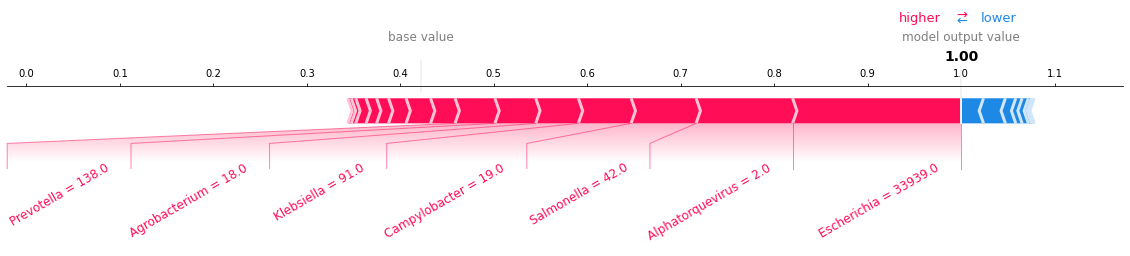

In [9]:
raw_CR = X[['Bacillus', 'Burkholderia', 'Enterococcus', 'Aeromonas', 'Cronobacter',
       'Cytomegalovirus', 'Lymphocryptovirus', 'Campylobacter', 'Pantoea',
       'Shigella', 'Klebsiella', 'Cellulomonas', 'Salmonella', 'Shewanella',
       'Megasphaera', 'Stenotrophomonas', 'Agrobacterium', 'Oerskovia',
       'Prevotella', 'Escherichia', 'Blautia', 'Bacteroides', 'Enterobacter',
       'Alphatorquevirus', 'Veillonella']].copy()

raw_CR_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 240, 'max_depth': 1, 'gamma': 1.711111111111111, 'colsample_bytree': 0.9052631578947369}
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

j = 202

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True,
                text_rotation=30)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')
plt.show()